# Anomaly Detection  
dataset from: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

This dataset is the KDD Cup 1999 Dataset, which is a list of network connection events classified into normal traffic and attacks. The data has a lot of information about the connections, and here is a summary of the most important features:

1. **duration**: Length of the connection in seconds.
2. **flag**: Status of the connection (e.g., SF for successful, REJ for rejected).
3. **src_bytes**: Bytes sent from the source to the destination.
4. **dst_bytes**: Bytes sent from the destination to the source.
5. **logged_in**: Whether the user successfully logged in (binary).
6. **count**: Number of connections to the same host in the last 2 seconds.
7. **dst_host_count**: Number of connections to the same destination host.
8. **dst_host_serror_rate**: Percentage of destination-host connections with "SYN" errors.

In [43]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [32]:
def load_data(first = False):
    if first or not os.path.exists('data/kddcup.pkl'):
        columns = [
            "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", 
            "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
            "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", 
            "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
            "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
            "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
            "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
            "dst_host_srv_rerror_rate", "target"
        ]
        data = pd.read_csv('data/kddcup.csv', names=columns, delimiter=',')
        data = data.loc[::10]
        data.reset_index(drop=True, inplace=True)
        pickle.dump(data, open('data/kddcup.pkl', 'wb'))
        return data
    else:
        return pickle.load(open('data/kddcup.pkl', 'rb'))


In [33]:
data = load_data(True)
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,210,624,0,0,0,0,...,109,1.0,0.0,0.06,0.05,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,256,1273,0,0,0,0,...,209,1.0,0.0,0.01,0.03,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,215,3670,0,0,0,0,...,255,1.0,0.0,0.03,0.05,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,370,520,0,0,0,0,...,255,1.0,0.0,0.01,0.04,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49398,0,tcp,http,SF,328,324,0,0,0,0,...,255,1.0,0.0,0.07,0.10,0.0,0.00,0.0,0.0,normal.
49399,0,tcp,http,SF,296,540,0,0,0,0,...,255,1.0,0.0,0.07,0.10,0.0,0.00,0.0,0.0,normal.
49400,0,tcp,http,SF,148,1122,0,0,0,0,...,255,1.0,0.0,0.33,0.04,0.0,0.00,0.0,0.0,normal.
49401,0,tcp,http,SF,291,236,0,0,0,0,...,255,1.0,0.0,0.04,0.06,0.0,0.01,0.0,0.0,normal.


I'm first going to get rid of a bunch of columns to make the dataset easier to handle. I'll remove all the ones where everything is one value the whole way through.

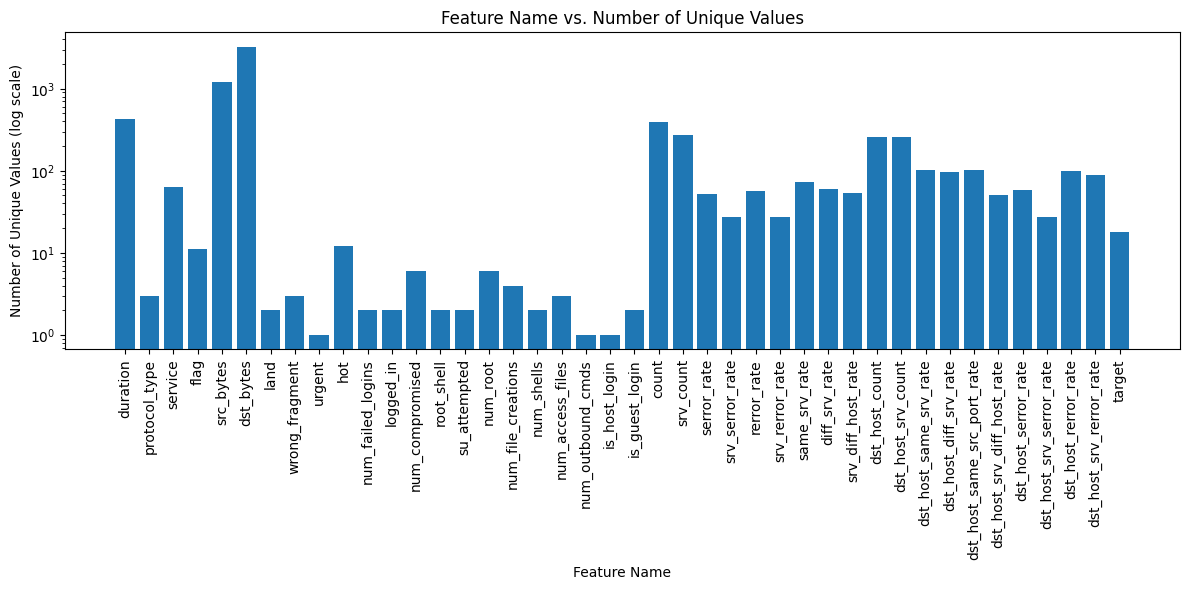

Columns with only one unique value:
['urgent', 'num_outbound_cmds', 'is_host_login']


In [34]:
import matplotlib.pyplot as plt

unique_values_count = {column: data[column].nunique() for column in data.columns}

plt.figure(figsize=(12, 6))
plt.bar(unique_values_count.keys(), unique_values_count.values())
plt.xticks(rotation=90)
plt.title("Feature Name vs. Number of Unique Values")
plt.xlabel("Feature Name")
plt.ylabel("Number of Unique Values (log scale)")
plt.yscale('log')
plt.tight_layout()
plt.show()

single_value_columns = [column for column, count in unique_values_count.items() if count == 1]
print("Columns with only one unique value:")
print(single_value_columns)


Here's a display of the feature distributions for each of the features in the dataset. I put it into a log scale so that values that show up once or twice are still visible in the graph.

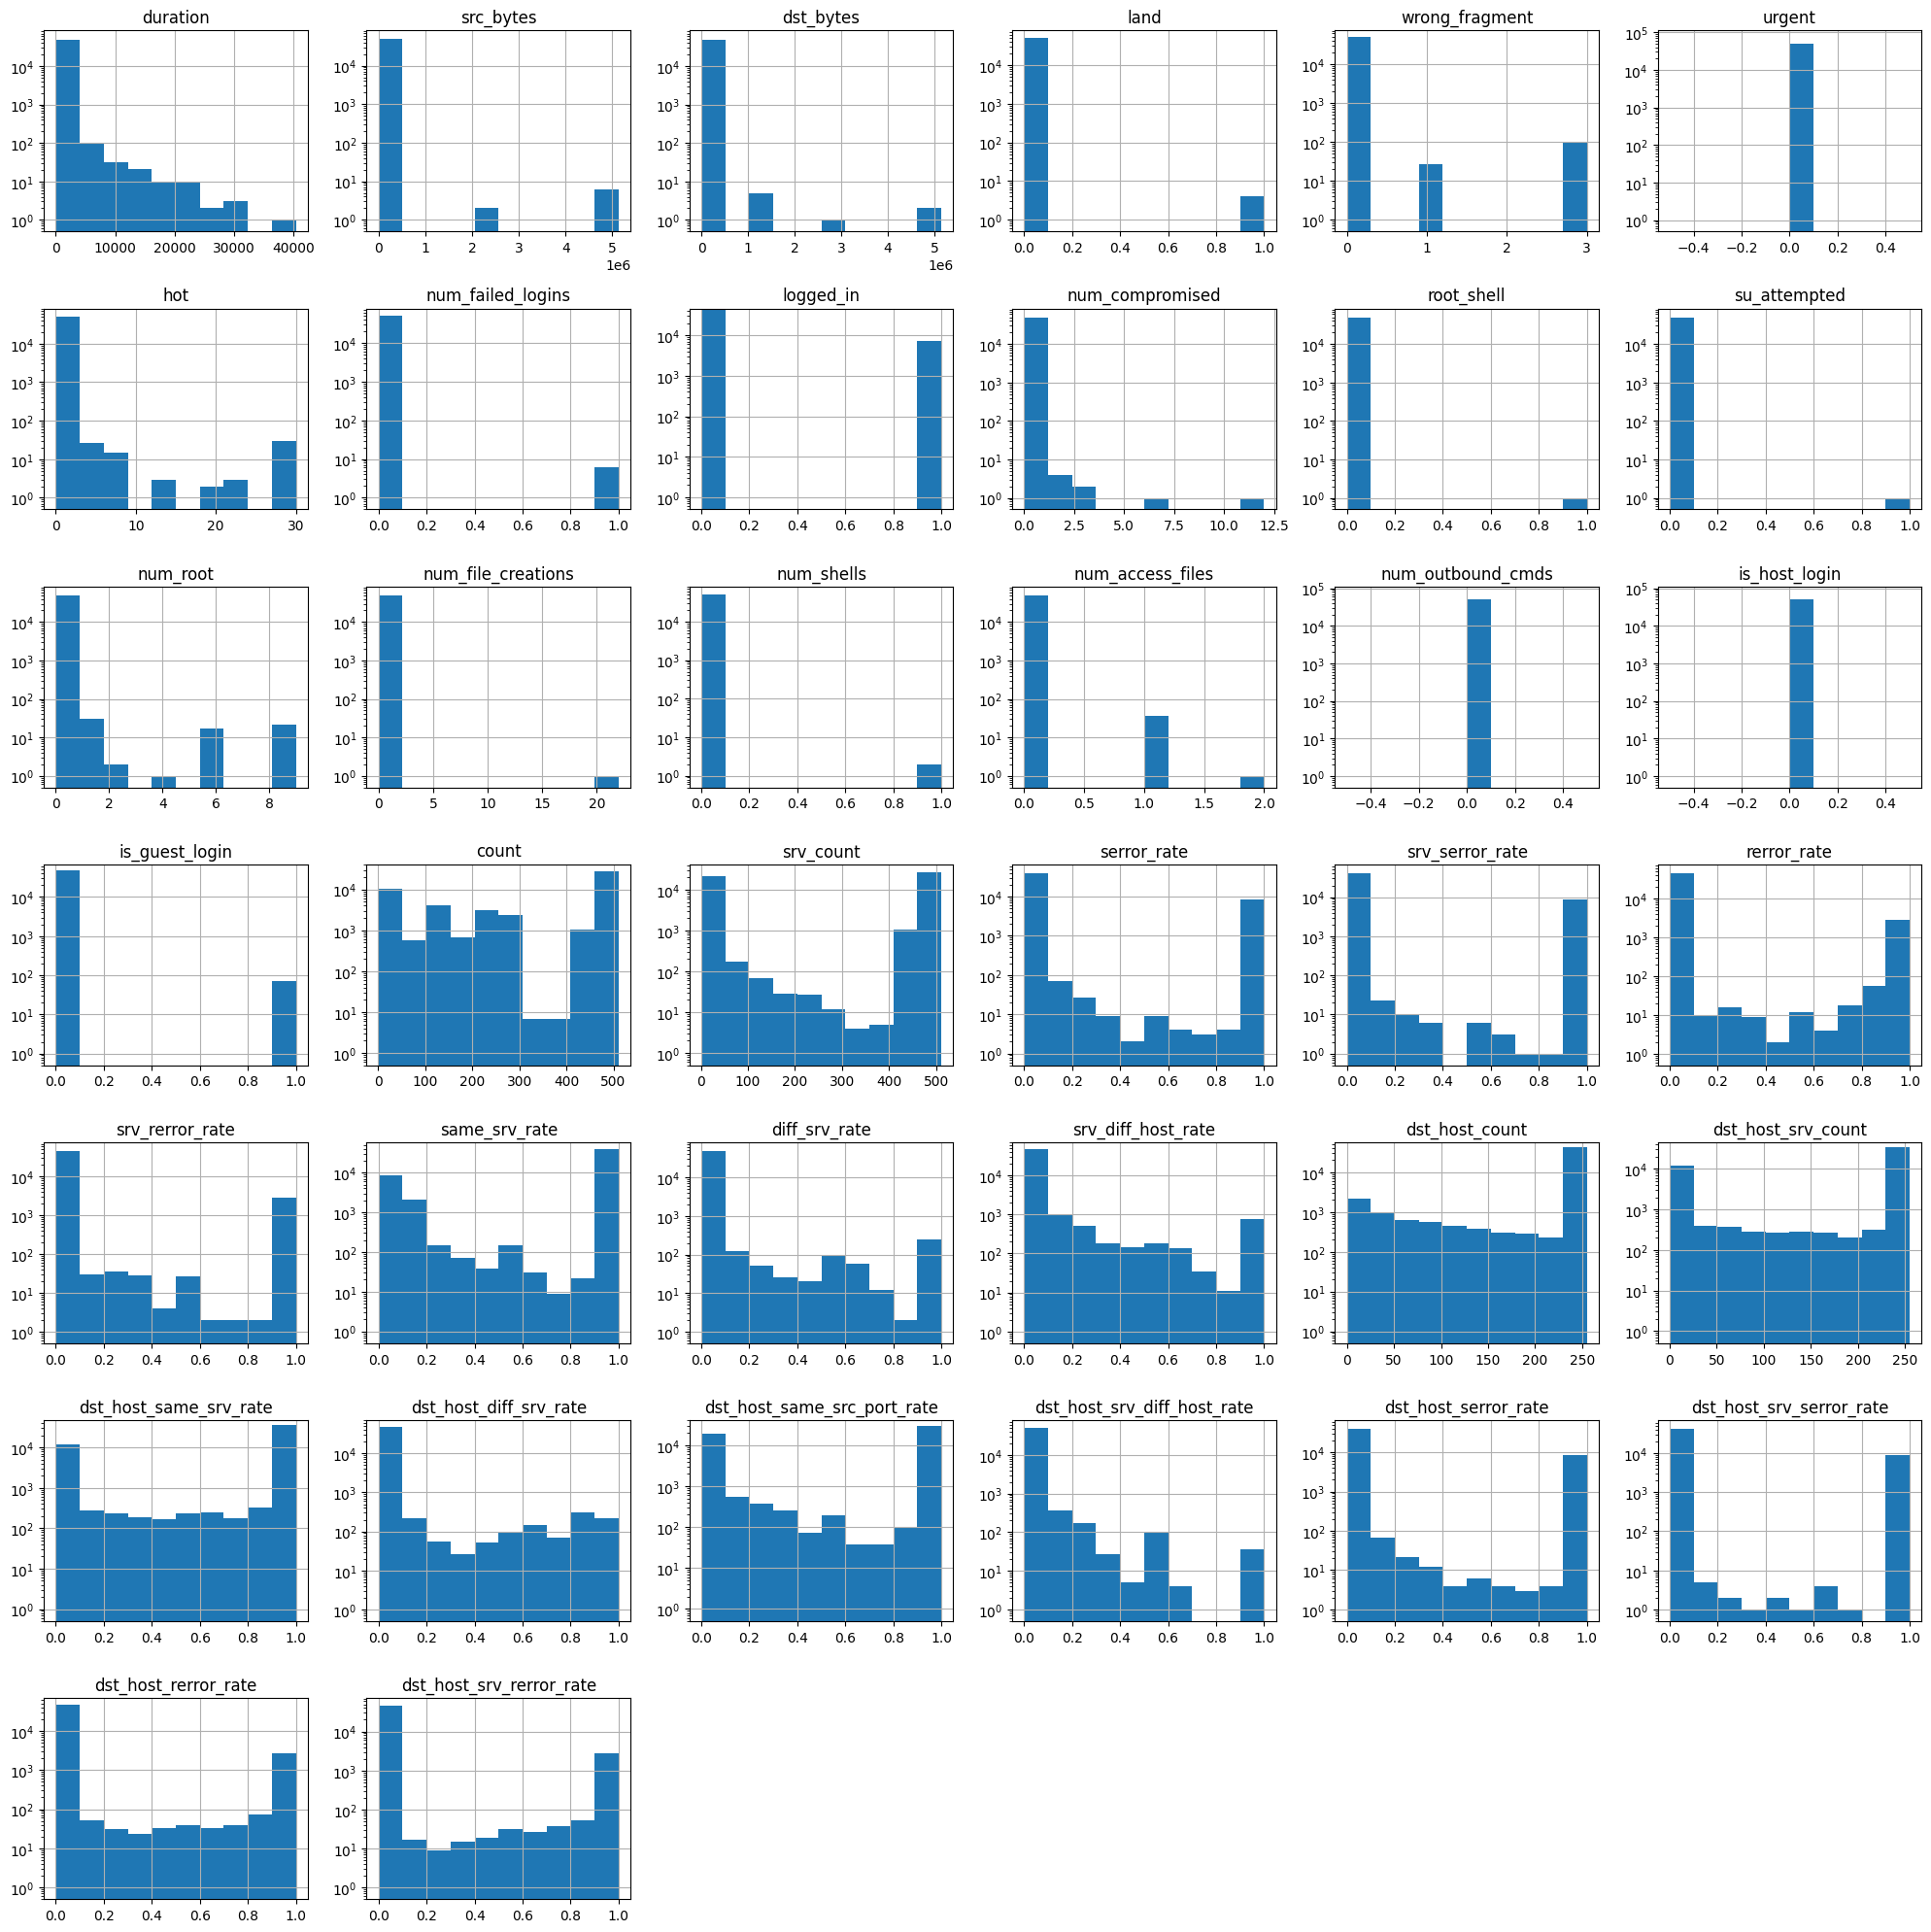

In [35]:
plotdata = data
axes = plotdata.hist(figsize=(20, 20), log=True)
for ax in axes.ravel():
    ax.set_ylim(bottom=0.5)
plt.tight_layout()
plt.show()

In [71]:
def preprocess_data(data):
    # Drop single-value columns
    single_value_columns = [column for column in data.columns if data[column].nunique() == 1]
    data = data.drop(columns=single_value_columns, errors='ignore')
    
    # One-hot encode categorical columns
    data = pd.get_dummies(data, columns=['protocol_type', 'service', 'flag'])
    
    # Reduce anomaly samples
    normal_data = data[data['target'] == 'normal.']
    anomaly_data = data[data['target'] != 'normal.']
    reduced_normal_data = normal_data.sample(frac=1/3, random_state=42)
    data = pd.concat([reduced_normal_data, anomaly_data], ignore_index=True)
    
    # normalize for pca
    scaler = StandardScaler()
    nd = data.drop(columns=['target'], errors='ignore')
    nd = pd.DataFrame(scaler.fit_transform(nd), columns=nd.columns)
    
    # encode target manually
    nd['target'] = data['target'].apply(lambda x: -1 if x == 'normal.' else 1)
    
    return nd

In [72]:
df = preprocess_data(data)
df['target'].value_counts()

target
 1    39677
-1     3242
Name: count, dtype: int64

I'm going to do a little PCA to get rid of some of the features. I'm keeping enough to explain 95% of the variance, which will probably get rid of a decent number of columns. Ironically enough, it looks like no attack is the anomaly here, rather than an attack taking place. 

In [73]:
X_raw = df.drop(columns=['target'])
y = df['target']

In [74]:
pca = PCA(n_components=None) 
X_pca = pca.fit_transform(X_raw)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

n_components = (cumulative_variance < 0.95).sum() + 1
print(f"Number of components to retain 95% variance: {n_components}")

# Reduce the dataset
pca = PCA(n_components=n_components)
X = pca.fit_transform(X_raw)

Number of components to retain 95% variance: 78


In [75]:
X

array([[-1.24978953,  0.94368592,  5.70994547, ...,  2.27844077,
        -0.48367216,  0.58767745],
       [-1.76078223,  1.51871458,  7.08729511, ..., -1.20454339,
         0.60398392, -0.28871716],
       [-0.00735079,  1.14950653,  5.10179775, ..., -1.47031625,
         1.27491871, -0.09229988],
       ...,
       [-1.60817263,  0.63108065,  1.84332302, ...,  2.67632033,
        -0.54049701, -0.52980055],
       [-1.51706345,  0.6259928 ,  1.82643538, ...,  2.67219424,
        -0.5407906 , -0.53615314],
       [-1.42595426,  0.62090495,  1.80954773, ...,  2.66806815,
        -0.5410842 , -0.54250574]], shape=(42919, 78))

I'll use an isolation forest to try to identify the anomalies.

In [76]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X)

y_pred = iso_forest.predict(X)

Here's a confusion matrix of the predictions:

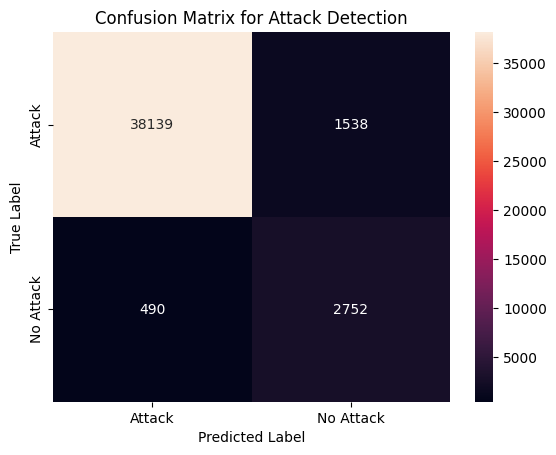

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, y_pred, labels=[1, -1])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Attack', 'No Attack'], yticklabels=['Attack', 'No Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix for Attack Detection")
plt.show()


In [87]:
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / cm.sum())
print("F1 Score:", 2 * cm[0, 0] / (2 * cm[0, 0] + cm[0, 1] + cm[1, 0]))

Accuracy: 0.9527482000978588
F1 Score: 0.9741016014098537


Both the accuracy and the F1 score are really good for this model, but that doesn't really mean anything since it's anomaly detection. The fact that no attack was the anomaly also likely had something to do with the classification. The model labeled more attacks as normal than it did regular interactions as attacks.